In [1]:
import PIL
from PIL import Image
from PIL.TiffTags import TAGS
import tkinter as tk
from tkinter import filedialog
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import exifread


## For Image Sequence

In [2]:
def frameanalyzer(mydir):
    abstimes = []
    totframes = 0

    root = tk.Tk()
    root.withdraw()
    files = ([x for x in mydir.iterdir() if x.is_file()])

    for filename in files:

        img = PIL.Image.open(filename)
        meta_dict = {TAGS[key] : img.tag[key] for key in img.tag}
        img.close()

        time = str(meta_dict['DateTime'][0])[-12:-1]
        abstime = float(time[0:2])*60*60 + float(time[3:5])*60 + float(time[6:11])
        #print(abstime)
        abstimes.append(abstime)

        totframes += 1
    

    difference = [abs(j - i) for i, j in zip(abstimes[: -1], abstimes[1 :])] 

    #remove outliers
    a = np.array(difference)
    upper_quartile = np.percentile(a, 99)
    lower_quartile = np.percentile(a, 1)
    IQR = (upper_quartile - lower_quartile) * 2
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    difference_notoutliers = []
    for y in a.tolist():
        if y >= quartileSet[0] and y <= quartileSet[1]:
            difference_notoutliers.append(y)

    outliers = len(difference) - len(difference_notoutliers)

    #create results directory

    newdirectory = str(mydir)+'-results'
    newmydir = Path(newdirectory)
    newmydir.mkdir(exist_ok=True)        



    x = np.arange(1,totframes)
    #Save
    data = {'Frame':x,'Difference':difference}
    df = pd.DataFrame(data)
    df.to_csv(newmydir/'frame_rates.csv',index=False)

    #Print
    result = {'Directory':[mydir],'Mean':[np.around(np.mean(difference_notoutliers),2)],'SD':[np.around(np.std(difference_notoutliers),2)],'Frames':[totframes-1],'Outliers':[outliers],'MeanWOutliers':[np.around(np.mean(difference),2)],'SDWOutliers':[np.around(np.std(difference),2)]}
    df = pd.DataFrame(result)
    df.to_csv(newmydir/'frame_rates_avg.csv',index=False)

    #Plot
    x = np.arange(1,totframes-outliers)

    fig, ax = plt.subplots(figsize=(28, 3))
    ax.plot(x, difference_notoutliers)
    plt.xlabel('Frame', fontsize = 25)
    plt.ylabel('Time (s)', fontsize = 25)
    plt.yticks(fontsize = 25)
    plt.xticks(fontsize = 25)
    plt.tight_layout()
    fig.savefig(newmydir/'frame_rates_plot.pdf')
    #plt.clf()
    
    return df

In [3]:
askdirectory = filedialog.askdirectory() # show an "Open" dialog box and return the path to the selected file
parentdir = Path(askdirectory)

In [4]:
folders = [x for x in parentdir.iterdir() if x.is_dir()]
folders = [i for i in folders if (str(i)[-1:] == 'w') == True]
folders

[WindowsPath('C:/Users/Brouhard Lab/Data/Images/2022-09-16-dynamics/2022-09-16_dynamics_Ch3-tub06uM/2022-09-16_dynamics_Ch3-tub06uM_raw')]

,Directory,Mean,SD,Frames,Outliers,MeanWOutliers,SDWOutliers
0,C:\Users\Brouhard Lab\Data\Images\2022-09-16-d...,5.02,0.02,400,5,10.05,100.44


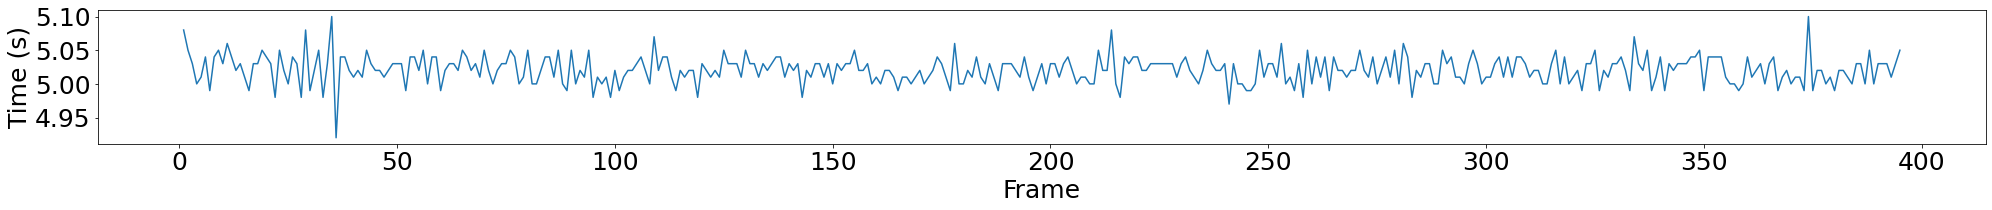

In [5]:
df = frameanalyzer(folders[0])
# for i in folders[1:]:
#     df0 = frameanalyzer(i)
#     df = df.append(df0)
# df.to_csv(parentdir/'frame_rates_avg.csv',index=False)
df

## For Hyperstack

In [19]:


myfile = filedialog.askopenfilename() # show an "Open" dialog box and return the path to the selected file
path = Path(myfile)
parentdir = path.parents[0]

mydir = parentdir
name = path.name.replace(path.suffix, '')
name = str(name)

f = open(myfile, 'rb')
tags = exifread.process_file(f)

abstimes = []

#for n in np.concatenate((np.arange(0,8), np.arange(15,25), np.arange(30,40)), axis = 0):
totframes = 0
for n in np.arange(0,len(tags)):
    
    try:
        
        text = 'IFD ' + str(n) + ' DateTime'

        minutes = float(str(tags[text])[-6:])
        hour2min = int(str(tags[text])[-9:-7])*60

        time = hour2min + minutes

        abstimes.append(time)

        totframes += 1
        
    except:
        
        pass
    
difference = [j - i for i, j in zip(abstimes[: -1], abstimes[1 :])]
#difference = [i for i in difference if i < 4.5]

if totframes == 0:
 raise KeyboardInterrupt

#remove outliers
a = np.array(difference)
upper_quartile = np.percentile(a, 99)
lower_quartile = np.percentile(a, 1)
IQR = (upper_quartile - lower_quartile) * 2
quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
difference_notoutliers = []
for y in a.tolist():
    if y >= quartileSet[0] and y <= quartileSet[1]:
        difference_notoutliers.append(y)

outliers = len(difference) - len(difference_notoutliers)

x = np.arange(1,totframes)
data = {'Frame':x,'Difference':difference}
data = pd.DataFrame(data)
data.to_csv(mydir/(name+'_frame_rate_difference.csv'),index=False)

#Print
result = {'Directory':[mydir],'Mean':[np.around(np.mean(difference_notoutliers),2)],'SD':[np.around(np.std(difference_notoutliers),2)],'Frames':[totframes-1],'Outliers':[outliers],'MeanWOutliers':[np.around(np.mean(difference),2)],'SDWOutliers':[np.around(np.std(difference),2)]}
df = pd.DataFrame(result)
df.to_csv(mydir/(name+'_frame_rates_avg.csv'),index=False)

df



,Directory,Mean,SD,Frames,Outliers,MeanWOutliers,SDWOutliers
0,D:\results\2021_WT_R303X_residence\2021-09-15_...,0.1,0.0,397,0,0.1,0.0


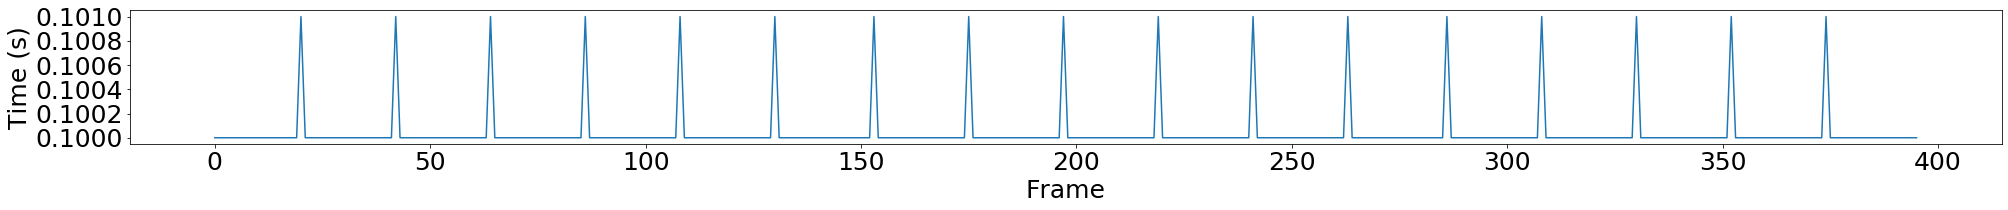

In [20]:
x = np.arange(0,len(difference))
fig, ax = plt.subplots(figsize=(28, 3))
ax.plot(x[:-1], difference[:-1])
plt.xlabel('Frame', fontsize = 25)
plt.ylabel('Time (s)', fontsize = 25)
#plt.ylim(0.099,0.1005)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tight_layout()
fig.savefig(mydir/(name+'_frame_rates.jpg'))


D:\Sofia\2020-07-29_IRM_DCX-WT-dynamincs\CH11_tub06uM_typeWT_DCX100nM
10.5 +/- 108.78
5.05 +/- 0.03 ignoring 1 outliers


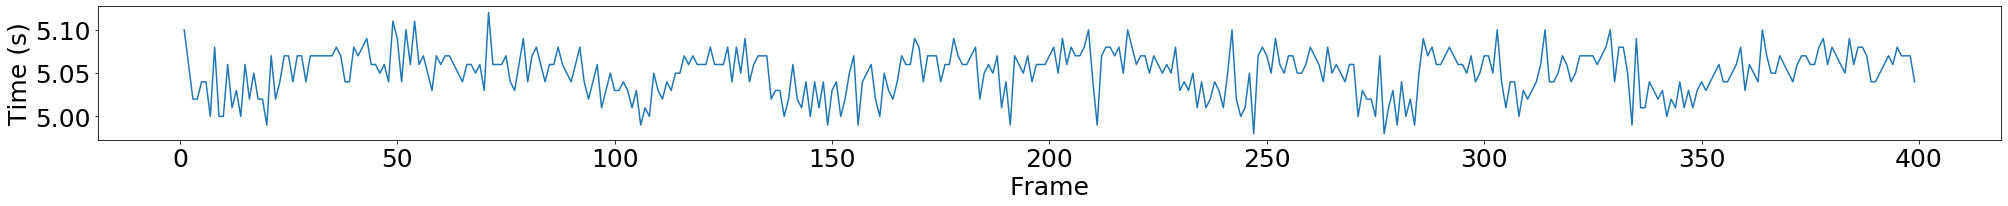

In [83]:
#def frameanalyzer()
abstimes = []
totframes = 0

root = tk.Tk()
root.withdraw()
mydir = folders[0]
files = ([x for x in mydir.iterdir() if x.is_file()])

for filename in files:

    img = PIL.Image.open(filename)
    meta_dict = {TAGS[key] : img.tag[key] for key in img.tag}
    img.close()

    time = str(meta_dict['DateTime'][0])[-12:-1]
    abstime = float(time[0:2])*60*60 + float(time[3:5])*60 + float(time[6:11])
    #print(abstime)
    abstimes.append(abstime)

    totframes += 1
    
difference = [abs(j - i) for i, j in zip(abstimes[: -1], abstimes[1 :])] 

#remove outliers
a = np.array(difference)
upper_quartile = np.percentile(a, 99)
lower_quartile = np.percentile(a, 1)
IQR = (upper_quartile - lower_quartile) * 10
quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
difference_notoutliers = []
for y in a.tolist():
    if y >= quartileSet[0] and y <= quartileSet[1]:
        difference_notoutliers.append(y)

outliers = len(difference) - len(difference_notoutliers)

#create results directory

newdirectory = askdirectory+'-results'
newmydir = Path(newdirectory)
newmydir.mkdir(exist_ok=True)        



x = np.arange(1,totframes)
#Save
data = {'Frame':x,'Difference':difference}
df = pd.DataFrame(data)
df.to_csv(newmydir/'frame_rates.csv',index=False)

#Print
result = {'Directory':[mydir],'Mean':[np.around(np.mean(difference_notoutliers),2)],'SD':[np.around(np.std(difference_notoutliers),2)],'Frames':[totframes-1],'Outliers':[outliers],'MeanWOutliers':[np.around(np.mean(difference),2)],'SDWOutliers':[np.around(np.std(difference),2)]}
df = pd.DataFrame(result)
df.to_csv(newmydir/'frame_rates_avg.csv',index=False)

#Plot
x = np.arange(1,totframes-outliers)

fig, ax = plt.subplots(figsize=(28, 3))
ax.plot(x, difference_notoutliers)
plt.xlabel('Frame', fontsize = 25)
plt.ylabel('Time (s)', fontsize = 25)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tight_layout()
fig.savefig(newmydir/'frame_rates_plot.pdf')

printstring = str(np.around(np.mean(difference),2)) + ' +/- ' + str(np.around(np.std(difference),2))
printstring_notoutliers = str(np.around(np.mean(difference_notoutliers),2)) + ' +/- ' + str(np.around(np.std(difference_notoutliers),2)) + ' ignoring ' + str(len(difference) - len(difference_notoutliers)) + ' outliers'

textoutput = str(mydir) + '\n' + printstring + '\n'  + printstring_notoutliers

#outputpath = mydir.parents[0]/'frame_rate_avg.txt'

#with open(outputpath, "w") as text_file:
#    text_file.write(textoutput)
    
print(textoutput)

In [5]:
myfile.parents

AttributeError: 'str' object has no attribute 'parents'